In [1]:
%matplotlib notebook

import os
import numpy as np 
import pandas as pd
import torch
from torch import nn
from torch.nn import functional as F 
import torch.utils.data as td
import torchvision as tv
from PIL import Image
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import socket
import getpass
import xml.etree.ElementTree as ET
import nntools as nt

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
print(torch.__version__)

1.1.0


In [4]:
dataset_root_dir = '/datasets/ee285f-public/PascalVOC2012'

In [5]:
class VOCDataset(td.Dataset):
    def __init__(self, root_dir, mode='train', image_size=(800, 800)): 
        super(VOCDataset, self).__init__()
        self.mode = mode
        self.image_size = image_size
        
        self.images_dir = os.path.join(root_dir, 'JPEGImages')
        self.images_idx = pd.read_csv(os.path.join(root_dir, 'ImageSets/Main' ,"%s.txt" % mode), sep=' ', header=None, error_bad_lines=False) 
        self.ann_dir    = os.path.join(root_dir, 'Annotations')
        
        self.labels_map = {'aeroplane':0,  'bicycle':1, 'bird':2,  'boat':3,      'bottle':4, 
                       'bus':5,        'car':6,      'cat':7,  'chair':8,     'cow':9,
                       'diningtable':10,'dog':11,    'horse':12,  'motorbike':13, 'person':14,
                       'pottedplant':15,'sheep':16,  'sofa':17,   'train':18,   'tvmonitor':19, 'background':20}

    def __len__(self):
        # Return the size of the dataset
        return len(self.images_idx)
    def __repr__(self):
        # Return the data is training set or testing set, and its image size
        return "VOCDataset(mode={}, image_size={})". \
            format(self.mode, self.image_size)
    
    def __getitem__(self, idx):
        # Return the preprocessed data (tensor) and labels.
        img_path = os.path.join(self.images_dir, self.images_idx.iloc[idx][0]+".jpg") 
        img = Image.open(img_path).convert('RGB')
        target = self.get_obj(self.images_idx.iloc[idx][0])
        target = self.encode(target)
        
        transform = tv.transforms.Compose([ 
            # resize the image
            tv.transforms.Resize(self.image_size), 
            # convert a PIL Image to tensor in range [0,1]
            tv.transforms.ToTensor(), 
            # normalize the tensor to [-1,1]
            #tv.transforms.Normalize((1/2,1/2,1/2),(1/2,1/2,1/2)) 
        ])
        # Transform
        img = transform(img)

        return img, target
    
    def get_obj(self, img_name):
        
        img = {'object':[]}
        seen_labels = {}   
        tree = ET.parse(os.path.join(self.ann_dir, img_name+".xml"))
     
        for elem in tree.iter():
            #print(elem.tag)
            if 'width' in elem.tag:
                img['width'] = int(elem.text)
                
            if 'height' in elem.tag:
                img['height'] = int(elem.text)
                
            if 'object' in elem.tag or 'part' in elem.tag:
                obj = {}
                for attr in list(elem):
                    
                    if 'name' in attr.tag:  
                        obj['name'] = attr.text
                        
                        img['object'] += [obj]  
 
                        if obj['name'] in seen_labels:
                            seen_labels[obj['name']] += 1
                        else:
                            seen_labels[obj['name']]  = 1
                           
                    if 'bndbox' in attr.tag:
                        for dim in list(attr):
                            if 'xmin' in dim.tag:       
                                obj['xmin'] = float(dim.text)
                            if 'ymin' in dim.tag:      
                                obj['ymin'] = float(dim.text)
                            if 'xmax' in dim.tag:           
                                obj['xmax'] = float(dim.text)
                            if 'ymax' in dim.tag:
                                obj['ymax'] = float(dim.text)
                                                                              
        return img
    
    def encode(self, objs):
        res = {'boxes':[],'labels':[]}
        frac_x = self.image_size[0] / objs['width']
        frac_y = self.image_size[0] / objs['height']
        
        for i in range(len(objs['object'])):
            if objs['object'][i]['name'] in self.labels_map.keys():
                res['labels'].append(self.labels_map[objs['object'][i]['name']])
                res['boxes'].append([objs['object'][i]['xmin']*frac_x, objs['object'][i]['ymin']*frac_y,
                                     objs['object'][i]['xmax']*frac_x,objs['object'][i]['ymax']*frac_y])
            else:
                res['labels'].append(self.labels_map['background'])
                res['boxes'].append([objs['object'][i]['xmin']*frac_x, objs['object'][i]['ymin']*frac_y,
                                     objs['object'][i]['xmax']*frac_x,objs['object'][i]['ymax']*frac_y])
        
        res['labels'] = torch.Tensor(res['labels']).int()
        res['boxes'] = torch.Tensor(res['boxes'])
        return res
    

In [6]:
def myimshow(image, boxes = [], ax = plt):
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1]) 
    image = image 
    image[image < 0] = 0
    image[image > 1] = 1 
    h = ax.imshow(image) 
    
    boxes['boxes'] = boxes['boxes'].to('cpu').numpy()
    boxes['labels'] = boxes['labels'].to('cpu').numpy()
    
    labels = ['aeroplane',  'bicycle', 'bird',  'boat',      'bottle', 
                       'bus',        'car',      'cat',  'chair',     'cow',
                       'diningtable','dog',    'horse',  'motorbike', 'person',
                       'pottedplant','sheep',  'sofa',   'train',   'tvmonitor', 'background']
    color = {}
    for i in range(len(labels)):    
        color[labels[i]] = np.random.random(3)
    
    for i in range(len(boxes['labels'])):

        ax.gca().add_patch(patches.Rectangle((boxes['boxes'][i][0],boxes['boxes'][i][1]),boxes['boxes'][i][2]- boxes['boxes'][i][0],boxes['boxes'][i][3]-boxes['boxes'][i][1],edgecolor=color[labels[boxes["labels"][i]]],facecolor='none'))
        ax.annotate(labels[boxes["labels"][i]], xy=(boxes['boxes'][i][2], boxes['boxes'][i][1]),va="center", ha="center",fontsize=5, bbox=dict(boxstyle="Square", fc=color[labels[boxes["labels"][i]]]))
    ax.axis('off') 
   
    return h

In [7]:
train_set = VOCDataset(dataset_root_dir)

In [8]:
[x, x_target] = train_set.__getitem__(1105)

In [9]:
x_target

{'boxes': tensor([[108.8000,   2.1333, 753.6000, 736.0000],
         [ 89.6000, 448.0000, 128.0000, 588.8000]]),
 'labels': tensor([ 5, 14], dtype=torch.int32)}

<IPython.core.display.Javascript object>


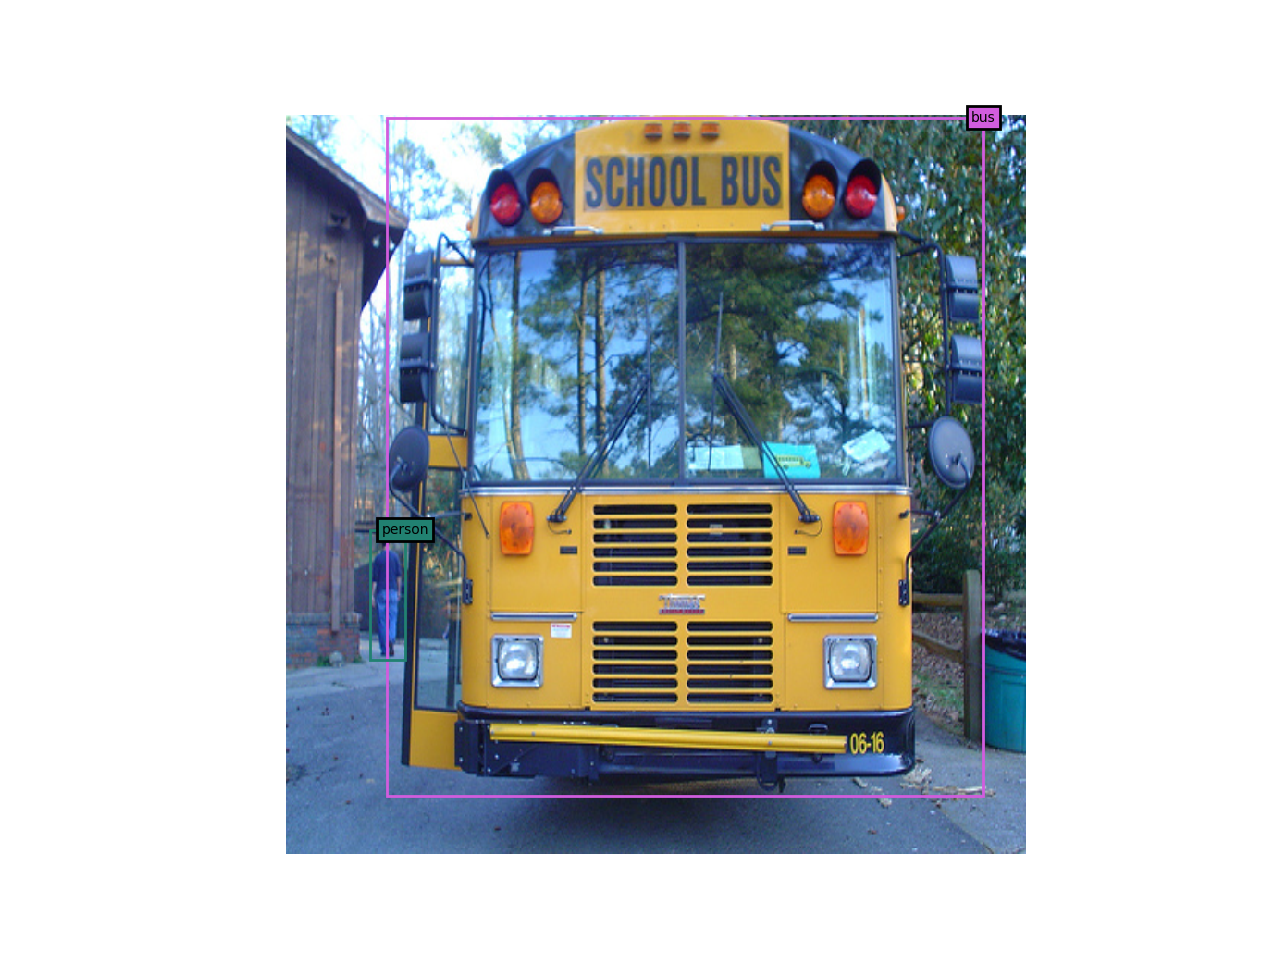

In [10]:
myimshow(x, boxes = x_target)

In [11]:
train_set = VOCDataset(dataset_root_dir)
val_set = VOCDataset(dataset_root_dir,mode="val")

In [12]:
# load a model pre-trained 
model = tv.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# replace the last layer to fit our dataset
num_classes = 21  # 20 classes + background
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor.cls_score = nn.Linear(in_features, num_classes)
model.roi_heads.box_predictor.bbox_pred =  nn.Linear(in_features, 4*num_classes)

In [13]:
class ClassificationStatsManager(nt.StatsManager):
    def __init__(self):
        super(ClassificationStatsManager, self).__init__()
        
    def init(self):
        super(ClassificationStatsManager, self).init() 
        
    def accumulate(self, loss, x, y, d): 
        super(ClassificationStatsManager, self).accumulate(loss, x, y, d) 
        
    def summarize(self):
        loss = super(ClassificationStatsManager, self).summarize() 
        return {'loss': loss}

In [15]:
# create experience
lr = 1e-3
model = model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=3,gamma=0.1)
stats_manager = ClassificationStatsManager()
exp1 = nt.Experiment(model, train_set, val_set, optimizer, scheduler, stats_manager,
                     output_dir="faster_rcnn_resnet50", perform_validation_during_training=True)

In [16]:
def plot(exp, fig, axes): 
    axes.clear()
    axes.plot([exp.history[k][0]['loss'] for k in range(exp.epoch)],
                 label="traininng loss")
    axes.plot([exp.history[k][1]['loss'] for k in range(exp.epoch)],
                 label="evaluation loss")
    axes.legend()
    axes.set(xlabel = 'Epoch', ylabel = 'Loss')
    plt.tight_layout()
    fig.canvas.draw()

<IPython.core.display.Javascript object>


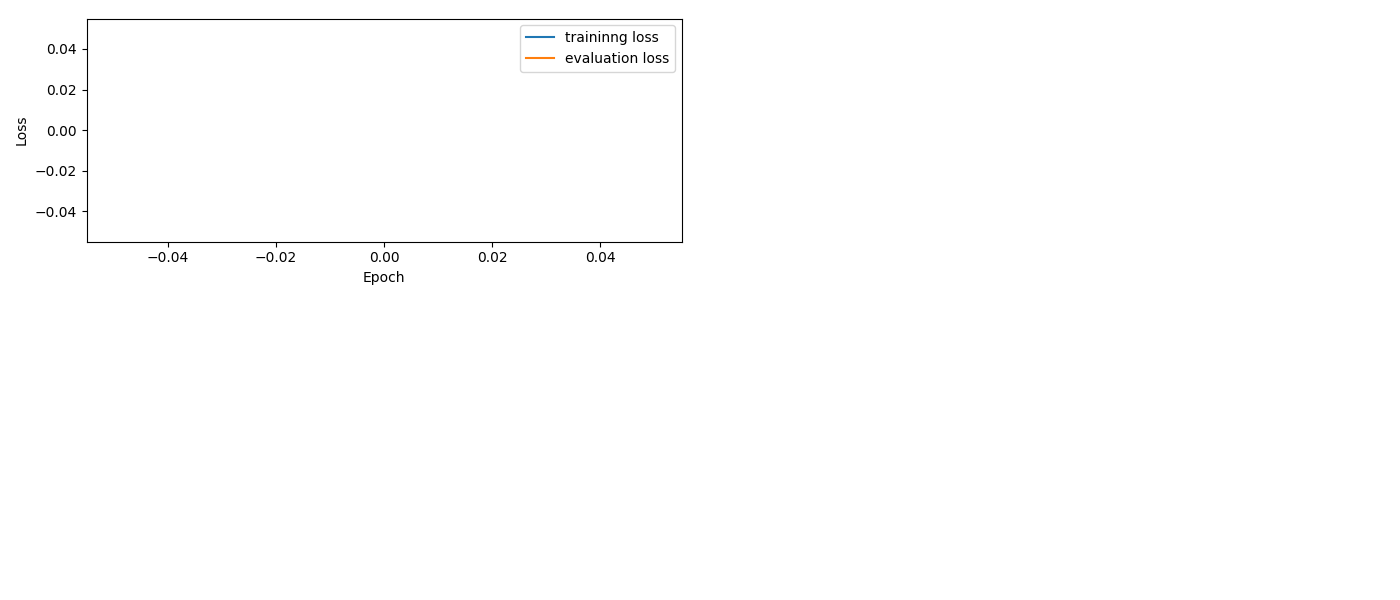

Start/Continue training from epoch 0


In [ ]:
# 跑呀跑～加油跑
fig, axes = plt.subplots(ncols=1, figsize=(7, 3))
exp1.run(num_epochs=10, plot=lambda exp: plot(exp, fig=fig, axes=axes))

In [23]:
# 这个不用跑啦啦啦啦
# Training model!
model.train()
T = 1
# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=3,gamma=0.1)

for epoch in range(T): 
    print('Epoch = ',epoch)
    #running_loss = {'loss_classifier':0.0, 'loss_box_reg':0.0, 'loss_objectness':0.0, 'loss_rpn_box_reg':0.0}
    running_loss = 0
    for minibatch_count, (images, targets) in enumerate(train_loader, start=1):
        
        images = images.to(device)
        targets['boxes'] = targets['boxes'].to(device)[0]
        targets['labels'] = targets['labels'].to(device)[0]

        # Initialize the gradients to zero
        optimizer.zero_grad()

        # Forward propagation and compute loss
        loss_dict = model(images,[targets])
        losses = sum(loss for loss in loss_dict.values())
        
        # Back propagation
        losses.backward()

        # Parameter update
        optimizer.step()

        # Print averaged loss per minibatch every 100 mini-batches 
        # Compute and print statistics
        with torch.no_grad():
            '''
            running_loss['loss_classifier'] += loss['loss_classifier']
            running_loss['loss_box_reg'] += loss['loss_box_reg']
            running_loss['loss_objectness'] += loss['loss_objectness']
            running_loss['loss_rpn_box_reg'] += loss['loss_rpn_box_reg']
            '''
            running_loss += losses
            if minibatch_count % 100 == 99:
                print('[%d, %5d] loss: %.3f' % 
                      (epoch + 1, minibatch_count + 1, running_loss / 100)) 
                running_loss = 0.0
            

Epoch =  0
[1,   100] loss: 0.514
[1,   200] loss: 0.518
[1,   300] loss: 0.558
[1,   400] loss: 0.356
[1,   500] loss: 0.420
[1,   600] loss: 0.404
[1,   700] loss: 0.465
[1,   800] loss: 0.427
[1,   900] loss: 0.416
[1,  1000] loss: 0.335
[1,  1100] loss: 0.544
[1,  1200] loss: 0.393
[1,  1300] loss: 0.387
[1,  1400] loss: 0.294
[1,  1500] loss: 0.348
[1,  1600] loss: 0.382
[1,  1700] loss: 0.371
[1,  1800] loss: 0.274
[1,  1900] loss: 0.359
[1,  2000] loss: 0.323
[1,  2100] loss: 0.371
[1,  2200] loss: 0.375
[1,  2300] loss: 0.319
[1,  2400] loss: 0.426
[1,  2500] loss: 0.356
[1,  2600] loss: 0.354
[1,  2700] loss: 0.308
[1,  2800] loss: 0.382
[1,  2900] loss: 0.367
[1,  3000] loss: 0.308
[1,  3100] loss: 0.342
[1,  3200] loss: 0.363
[1,  3300] loss: 0.322
[1,  3400] loss: 0.333
[1,  3500] loss: 0.334
[1,  3600] loss: 0.321
[1,  3700] loss: 0.261
[1,  3800] loss: 0.349
[1,  3900] loss: 0.312
[1,  4000] loss: 0.373
[1,  4100] loss: 0.312
[1,  4200] loss: 0.318
[1,  4300] loss: 0.323


In [38]:
loss_dict

{'loss_classifier': tensor(0.1127, device='cuda:0', grad_fn=<NllLossBackward>),
 'loss_box_reg': tensor(0.0974, device='cuda:0', grad_fn=<DivBackward0>),
 'loss_objectness': tensor(0.0273, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>),
 'loss_rpn_box_reg': tensor(0.0379, device='cuda:0', grad_fn=<DivBackward0>)}

In [28]:
model.eval()
for images, targets in val_loader:
    # move data to device
    images = images.to(device)
    targets['boxes'] = targets['boxes'].to(device)[0]
    targets['labels'] = targets['labels'].to(device)[0]
    
    prediction = model(images)
    print(prediction)
    print("---------------------------------")
    print(targets)
    
    break

[{'boxes': tensor([[374.4742, 220.7027, 463.5748, 436.1435],
        [477.0415, 236.3928, 575.5138, 412.1476],
        [463.3750, 258.2787, 571.4507, 400.8838],
        [384.3687, 225.1954, 577.1046, 436.9196],
        [382.0719, 234.1228, 573.7437, 423.7662],
        [382.4032, 210.5388, 534.4592, 415.0869],
        [ 73.3072, 211.2398, 766.9561, 793.0952],
        [ 43.4247, 246.0717, 757.0149, 776.2449],
        [ 49.3663, 252.2877, 755.4921, 779.8656],
        [ 48.8608, 296.1791, 799.8177, 787.5560],
        [482.4905, 246.7608, 552.8614, 377.7277],
        [ 20.2869, 109.6546, 772.6776, 779.2020]], device='cuda:0',
       grad_fn=<StackBackward>), 'labels': tensor([14,  1, 13,  1, 13, 14,  1,  2, 10,  7, 14,  3], device='cuda:0'), 'scores': tensor([0.9069, 0.4874, 0.3224, 0.2957, 0.2552, 0.0973, 0.0877, 0.0783, 0.0663,
        0.0573, 0.0517, 0.0500], device='cuda:0', grad_fn=<IndexBackward>)}]
---------------------------------
{'boxes': tensor([[460.8000, 252.2523, 576.0000, 420

In [30]:
prediction[0]

{'boxes': tensor([[374.4742, 220.7027, 463.5748, 436.1435],
         [477.0415, 236.3928, 575.5138, 412.1476],
         [463.3750, 258.2787, 571.4507, 400.8838],
         [384.3687, 225.1954, 577.1046, 436.9196],
         [382.0719, 234.1228, 573.7437, 423.7662],
         [382.4032, 210.5388, 534.4592, 415.0869],
         [ 73.3072, 211.2398, 766.9561, 793.0952],
         [ 43.4247, 246.0717, 757.0149, 776.2449],
         [ 49.3663, 252.2877, 755.4921, 779.8656],
         [ 48.8608, 296.1791, 799.8177, 787.5560],
         [482.4905, 246.7608, 552.8614, 377.7277],
         [ 20.2869, 109.6546, 772.6776, 779.2020]], device='cuda:0',
        grad_fn=<StackBackward>),
 'labels': tensor([14,  1, 13,  1, 13, 14,  1,  2, 10,  7, 14,  3], device='cuda:0'),
 'scores': tensor([0.9069, 0.4874, 0.3224, 0.2957, 0.2552, 0.0973, 0.0877, 0.0783, 0.0663,
         0.0573, 0.0517, 0.0500], device='cuda:0', grad_fn=<IndexBackward>)}

In [32]:
def myimshow_score(image, obj, ax = plt):
    image = image.to('cpu').numpy()
    names = obj['labels'].detach().to('cpu').numpy().astype(int)
    boxes = obj['boxes'].detach().to('cpu').numpy()
    scores = obj['scores'].detach().to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1]) 
    image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1 
    h = ax.imshow(image) 
    
    labels = ['aeroplane',  'bicycle', 'bird',  'boat',      'bottle', 
                       'bus',        'car',      'cat',  'chair',     'cow',
                       'diningtable','dog',    'horse',  'motorbike', 'person',
                       'pottedplant','sheep',  'sofa',   'train',   'tvmonitor', 'background']
    color = {}
    for i in range(len(labels)):    
        color[labels[i]] = np.random.random(3)
    
    for i in range(len(names)):

        ax.gca().add_patch(patches.Rectangle((boxes[i][0],boxes[i][1]),boxes[i][2]- boxes[i][0],boxes[i][3]-boxes[i][1],edgecolor=color[labels[names[i]]],facecolor='none'))
        ax.annotate(labels[names[i]]+ ':' + str(scores[i]), xy=(boxes[i][2], boxes[i][1]),va="center", ha="center",fontsize=5, bbox=dict(boxstyle="Square", fc=color[labels[names[i]]]))
    ax.axis('off') 
   
    return h




<IPython.core.display.Javascript object>


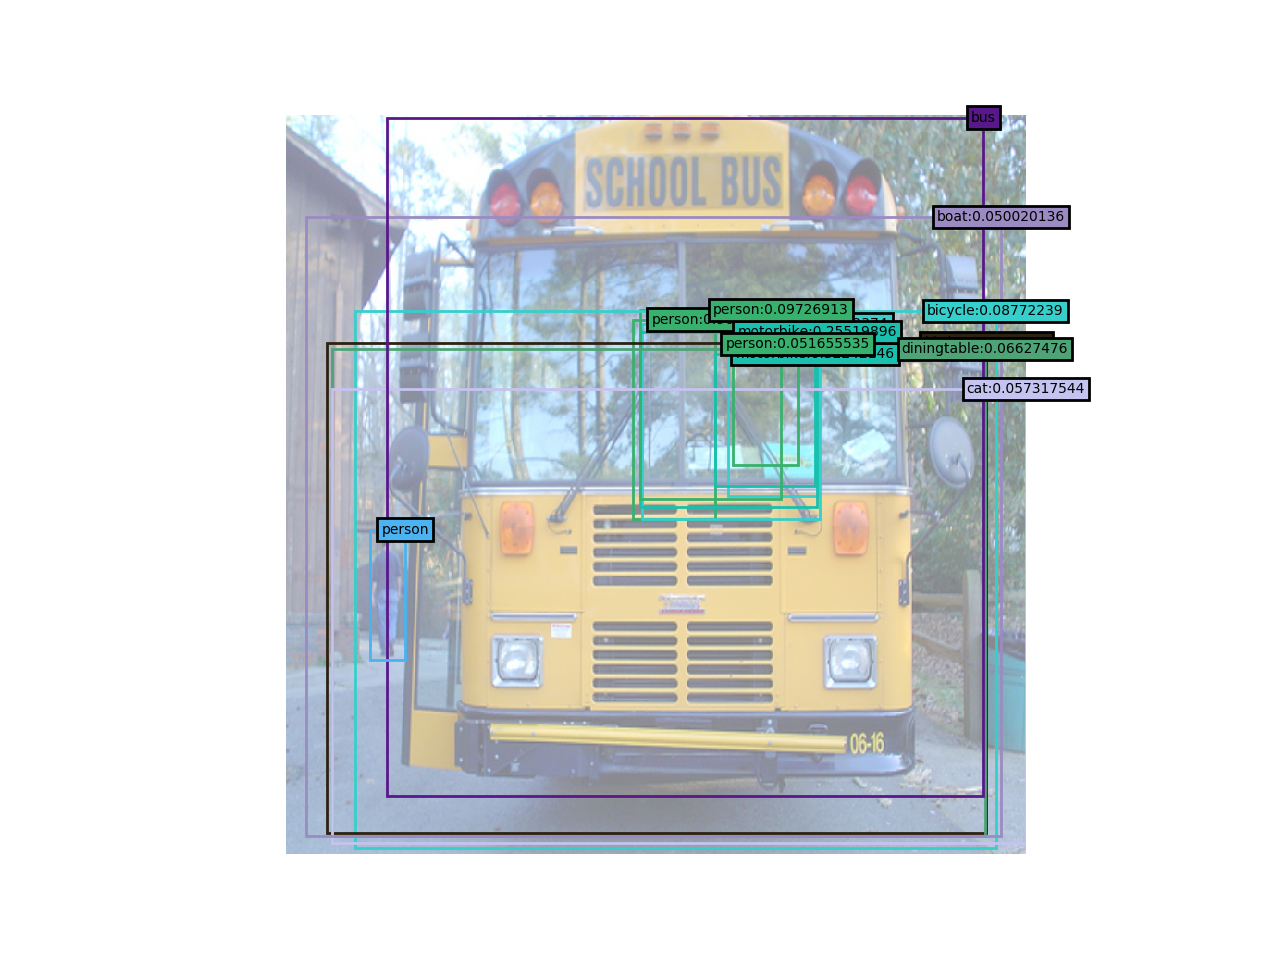

In [34]:
myimshow_score(images[0],prediction[0])